In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import least_squares

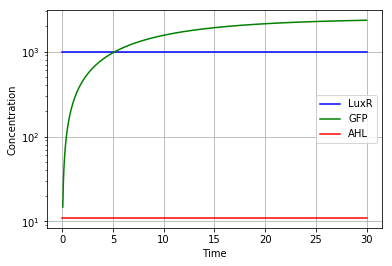

In [2]:
def report_params(fit_params_values, fit_param_names):
    for each in range(len(fit_param_names)):
        print(fit_param_names[each], 'is', fit_params_values[each])

# define your modules
def pCon1():
    # This is the module for a specific insubstatiation of a constituitive promoter
    # the input is nothing
    # the output is a protein production amount per time unit
    pCon1_production_rate = 100
    
    return pCon1_production_rate
    
def pLux1(LuxR, AHL):
    # This is the module for a specific insubstatiation of a lux promoter
    # the input is a LuxR amount and an AHL amount
    # the output is a protein production amount per time unit
    
    # For every promoter there is some function that determines what the promoter's
    #     maximal and basal expression are based on the amount of transcriptional factor
    #     is floating around in the cell. These numbers are empircally determined, and
    #     for demonstration purposes are fictionally and arbitrarily filled in here. 
    #     These functions take the form of hill functions.
    
    basal_n = 2
    basal_basal = 2
    basal_max = 2
    basal_kd = 2
    basal_expression_rate = basal_basal + (basal_max * (LuxR**basal_n / (LuxR**basal_n + basal_kd)))
    
    max_n = 2
    max_max = 2
    max_kd = 2
    maximal_expression_rate = (LuxR**max_n / (LuxR**max_n + max_kd))
    
    
    pLux1_n = 2
    pLux1_kd = 10
     
    pLux1_production_rate = basal_expression_rate + maximal_expression_rate*(AHL**pLux1_n / (pLux1_kd + AHL**pLux1_n)) 
    
    return pLux1_production_rate

def simulation_set_of_equations(y, t, *args):
    # Args are strictly for parameters we want to eventually estimate.
    # Everything else must be hardcoded below. Sorry for the convience. 
    
    # Unpack your parameters
    k_pCon_express = args[0] # A summation of transcription and translation from a pCon promoter
    k_pLux_express = args[1] # A summation of transcription and translation from a pLux promoter
    k_loss = args[2] # A summation of dilution and degredation
    
    # Unpack your current amount of each species
    LuxR, GFP, AHL = y
    
    # Determine the change in each species
    dLuxR = pCon1() - k_loss*LuxR
    dGFP = pLux1(LuxR, AHL)*k_pLux_express - k_loss*GFP
    dAHL = 0 # for now we're assuming AHL was added exogenously and never degrades
    
    # Return the change in each species; make sure same order as your init values
    # scipy.odeint will take these values and apply them to the current value of each species in the next time step for you
    return [dLuxR, dGFP, dAHL]
 
# Parameters
k_pCon_express = 101
k_pLux_express = 50
k_loss = 0.1
params = (k_pCon_express, k_pLux_express, k_loss)
param_names = ['k_pCon_express', 'k_pLux_express', 'k_loss'] # somehow this is honestly necessary in Python?!
 
# Initial Conditions
# LuxR, GFP, AHL
init_P = [1000, 0, 11]
  
# Timesteps
n_steps = 500
t = np.linspace(0, 30, n_steps) 
  
num_P = odeint(simulation_set_of_equations, init_P, t, args = (params))
plt.plot(t, num_P[:,0], c='b', label = 'LuxR')
plt.plot(t, num_P[:,1], c='g', label = 'GFP')
plt.plot(t, num_P[:,2], c='r', label = 'AHL')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(loc = 'best')
plt.grid()
plt.yscale('log')

plt.show()

In [3]:
noise = np.random.normal(0, 10, num_P.shape)
exp_P = num_P + noise
exp_t = t[::10]
exp_P = exp_P[::10]
# Create experimental data. Just take the regular simulation data and add some gaussian noise to it.

In [4]:
def residuals(params):
    params = tuple(params)
    sim_P = odeint(simulation_set_of_equations, init_P, exp_t, args = params)
    res = sim_P - exp_P
    return res.flatten()

initial_guess = (100, 100, 100)
low_bounds = [0, 0, 0]
up_bounds = [1000, 1000, 1000]

fitted_params = least_squares(residuals, initial_guess, bounds=(low_bounds, up_bounds)).x
# small reminder: .x is the fitted paramaters attribute of the least_squares output

# With least_squares function, unlike, say, curve_fit, it does not compute the covariance matrix for you
# TODO calculate standard deviation of paramater estimation 
# (will this ever be used other than sanity checking?)

print(params)
report_params(fitted_params, param_names)

(101, 50, 0.1)
k_pCon_express is 100.0
k_pLux_express is 49.9942246627
k_loss is 0.100037839987


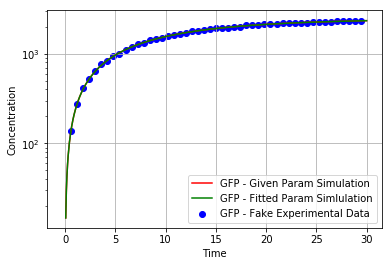

In [5]:
plt.plot(t, odeint(simulation_set_of_equations, init_P, t, args = tuple(params))[:,1], c='r', label='GFP - Given Param Simulation')
plt.scatter(exp_t, exp_P[:,1], c='b', label='GFP - Fake Experimental Data')
plt.plot(t, odeint(simulation_set_of_equations, init_P, t, args = tuple(fitted_params))[:,1], c='g', label='GFP - Fitted Param Simlulation')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.grid()
plt.yscale('log')
plt.show()